# Problem statement


* To prepare a complete data analysis report on the given data.

* To create a model which can classify the three major attacking diseases of rice plants like leaf blast, bacterial blight and brown spot.

* Analyze various techniques like Data Augmentation etc and create a report on that.

# Importing the libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Setting the constants

In [2]:

IMAGE_SIZE=256
BATCH_SIZE=10
channels=3
epochs = 100

# Importing data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
'Data',shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE)

Found 119 files belonging to 3 classes.



# Domain analysis and Data Information
* Rice is one of the most important staple crops worldwide, providing sustenance to over half of the world's population. However, rice plants are vulnerable to several diseases that can severely impact the yield and quality of rice production. Some of the major rice diseases that affect rice plants include bacterial leaf blight, brown spot, and leaf smut.

This dataset contains 120 jpg images of disease-infected rice leaves. The images are grouped into 3 classes based on the type of disease. There are 40 images in each class.

Classes :

● Leaf smut ● Brown spot ● Bacterial leaf blight

* Leaf smut caused by the fungus Entyloma oryzae, is a relatively less common rice disease. The symptoms of leaf smut include the formation of small, round, and reddish-brown spots on the leaves. These spots later turn black and produce powdery spores. Although leaf smut does not usually cause significant yield losses, it can affect the quality of rice grains by reducing their weight and size .

* Brown spot, caused by the fungus Cochliobolus miyabeanus, is another major rice disease that can cause significant yield losses. The disease is characterized by small, oval to elliptical spots on the leaves, which turn brown with a yellow halo. In severe cases, the spots can coalesce and cause the leaves to wither and die. Brown spot can also affect the panicles, leading to a reduction in grain quality and yield .

* Bacterial leaf blight, caused by the bacterium Xanthomonas oryzae pv. oryzae, is a serious disease that can cause extensive damage to rice plants. The symptoms of bacterial leaf blight include water-soaked lesions on the leaves, which later turn brown and dry up. In severe cases, the disease can cause wilting and death of the plant, leading to a significant reduction in crop yield .



In [4]:
#class names
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [5]:
#total batches
len(dataset)


12

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())


(10, 256, 256, 3)
[0 1 2 0 0 2 1 2 0 2]


# Observations

* Each element in the dataset is a tuple. First element is a batch of 10 elements of images. Second element is a batch of 10 elements of class labels

# Data visualization

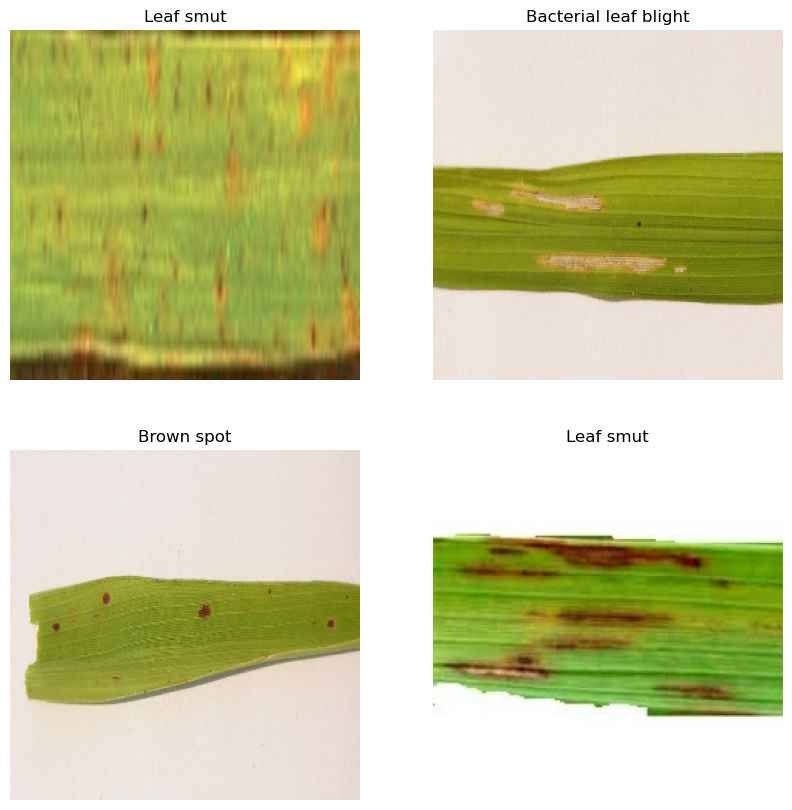

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')



# Creating function to split the data for training, testing and validation.

Dividing dataset into 3 parts. Namely:

* Training: Dataset to be used while training
* Validation: Dataset to be tested against while training
* Test: Dataset to be tested against after we trained a model



In [8]:
def get_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = 8
    val_size = 2
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds


In [9]:
train_ds,val_ds,test_ds = get_partition_tf(dataset)

In [10]:
len(test_ds)

2

# Chache, shuffle and prefetch the dataset
### Catche -

    Instead of recomputing these values for each training iteration, the CNN can access and reuse them, which significantly speeds up training. This is especially helpful in CNNs where data augmentation or complex preprocessing is involved.

### Prefetch -

    During CNN training, there are often periods where the model is computing gradients while waiting for the next batch of data to load. Prefetching allows us to start loading the next batch in the background while the model is training on the current batch. This overlapping of operations helps keep the GPU or CPU busy and can lead to faster training times.

### Shuffle -

    If we feed the CNN consecutive batches of data that are highly correlated (e.g., all images of one class followed by another), the model may learn patterns based on this order, which can lead to poor generalization. Shuffling ensures that each batch contains a random mix of samples from different classes, making the training process more robust.



In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)



# Creating a Layer for Resizing and Normalization

* Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

* You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it



In [13]:
##preprocessing
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])


# Data Augmentation

* Data augmentation is a technique used to increase the size and diversity of a dataset by applying various transformations to the existing data. This technique has become an essential tool in computer vision and image processing tasks, such as object recognition and classification, due to its ability to enhance the generalization ability of machine learning models and prevent overfitting.

* In the context of our rice leaf disease image classification project, data augmentation can play a crucial role in improving the performance and robustness of our model. By generating new images with different variations such as rotations, flips, zooms, and other transformations, we can increase the diversity of our dataset and provide our model with more examples to learn from, which can lead to better classification accuracy and robustness to variations in the real-world data.

In [15]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [16]:
# Applying Data Augmentation on train dataset

train_ds = train_ds.map(
    lambda x, y: (data_aug(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


# Model Architecture

* Here use a CNN coupled with a Softmax Activation in the output layerand also add the initial layers for Resizing, Normalization and Data Augmentation.

In [17]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D(2,2),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [18]:
#architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (10, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (10, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (10, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (10, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (10, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (10, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (10, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (10, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (10, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (10, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (10, 12, 12, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (10, 6, 6, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (10, 1152)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (10, 64)                    │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (10, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 185,699 (725.39 KB)

 Trainable params: 185,699 (725.39 KB)

 Non-trainable params: 0 (0.00 B)

# Compiling the Model

* We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric.

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history = model.fit(train_ds,epochs=epochs,batch_size=BATCH_SIZE,verbose=1,
         validation_data=val_ds)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 354ms/step - accuracy: 0.3786 - loss: 1.1094 - val_accuracy: 0.3000 - val_loss: 1.0976
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.3799 - loss: 1.0948 - val_accuracy: 0.5500 - val_loss: 1.0807
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.3299 - loss: 1.1005 - val_accuracy: 0.5500 - val_loss: 1.0703
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 0.3463 - loss: 1.0871 - val_accuracy: 0.5500 - val_loss: 1.0475
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.3242 - loss: 1.0813 - val_accuracy: 0.5000 - val_loss: 1.0277
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.5176 - loss: 1.0169 - val_accuracy: 0.5000 - val_loss: 1.0135
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.3806 - loss: 1.0176 - val_accuracy: 0.5500 - val_loss: 1.0493
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.5206 - loss: 0.9133 - val_accuracy: 0.6000 - v

In [21]:
score = model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9000 - loss: 0.5675


In [22]:
score

[0.49528488516807556, 0.8999999761581421]

# Plotting the Accuracy and Loss Curves

In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 8}

In [26]:
history.history.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

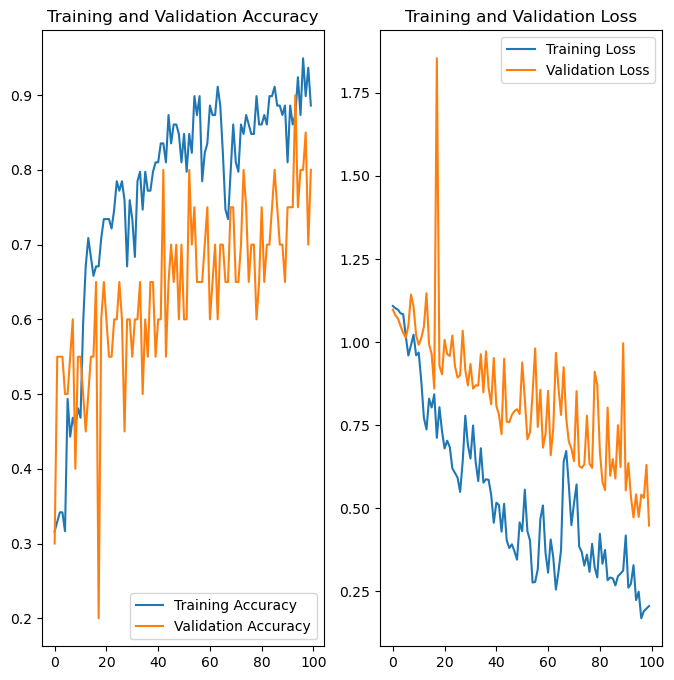

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

first image to predict
actual label: Brown spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
predicted label: Brown spot


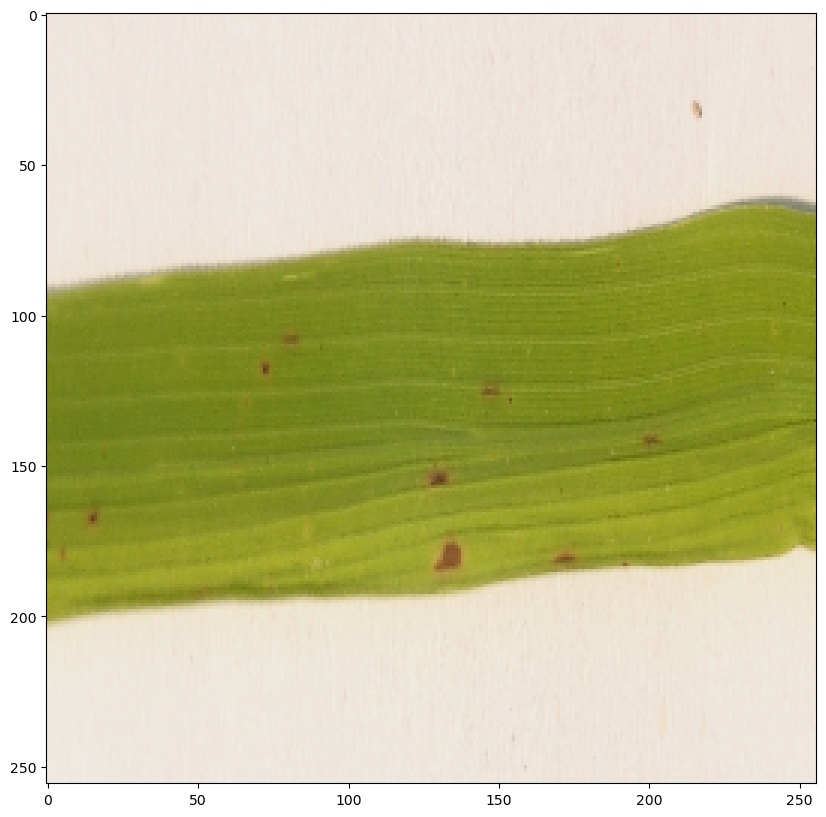

In [29]:
#prediction on sample
plt.figure(figsize=(10,10))
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Creating a function for inference

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Prediction on few Sample Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


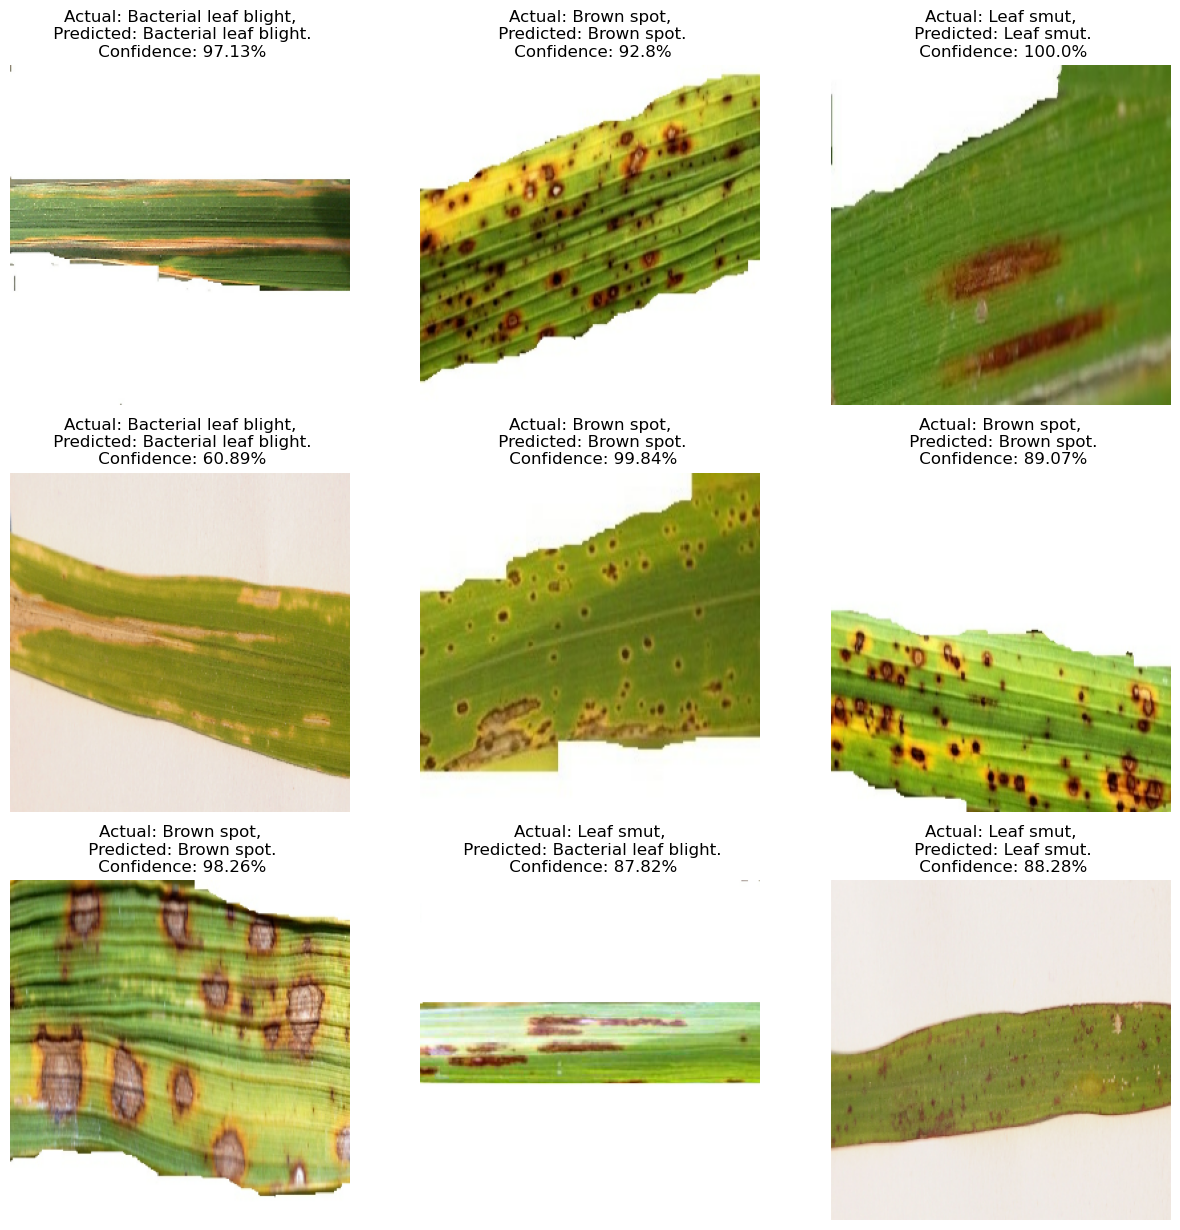

In [31]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


# Summary

* The project involved building a deep learning model to classify images of rice leaf disease. The dataset contained images from 3 type of rice leaf disease namely bacterial bligh, brown spot, and leaf smut. The project was divided into several steps, including data exploration, data preprocessing, building and training deep learning models, and evaluating model performance.

* During data exploration, we analyzed the dataset and visualized the images to get a better understanding of the data. We observed that the dataset was balanced, with an equal number of images for rice leaf diseases. We also noticed that the images were of different sizes and needed to be resized to a uniform size before being used for training. We have rescaled them to uniform size of 256 X 256.

* For data preprocessing, We have normalized the training dataset . We used Keras' ImageDataGenerator to generate augmented images to increase the size of the dataset and reduce overfitting. We also resized the images and divided them into training, validation, and testing sets.

* We built deep learning models by applying transfer learning technique, we trained model on augmented datasets and evaluated their performance using accuracy, loss, and time taken per epoch.

# Problem Challenge -
### Limited amount of data:

* One of the biggest challenges in the project was the limited amount of data available for training the models. We had only 119 images from 3 classes. This could lead to overfitting, where the model memorizes the training data and does not generalize well to new data. To deal with this challenge, data augmentation techniques were used to artificially increase the size of the dataset. This helped to improve the performance of the models and reduce overfitting.

### Complexity of deep learning models:

* Deep learning models can be very complex and have a large number of parameters, which makes them difficult to train and optimize. To deal with this challenge, various techniques such as regularization, and early stopping were used to prevent overfitting and improve the performance of the models.

### Hardware limitations:

* Deep learning models require a lot of computational resources, especially when training on large datasets. This can be a challenge if we don't have access to powerful hardware. To deal with this challenge, cloud computing services such as Google Colab were used to train the models, which provided access to powerful GPUs without the need for expensive hardware.

